[**Parallelization Workflow Pattern**](https://docs.langchain.com/oss/python/langgraph/workflows-agents)

With parallelization, LLMs work simultaneously on a task. This is either done by running multiple independent subtasks at the same time, or running the same task multiple times to check for different outputs. Parallelization is commonly used to:
- Split up subtasks and run them in parallel, which increases speed
- Run tasks multiple times to check for different outputs, which increases confidence

<img src="../assets/parallelization_pattern.png" width="400"/>

The example in this notebook showcases this parallelization design pattern. LLM first generates a nuanced joke creation prompt on any topic of choice provided by the user. This prompt is sent to 3 different LLM models. These LLMs work in parallel to produce their respective jokes. These jokes are then passed to another LLM judge to rank them  from best to worst based on humor and clarity.

Workflow diagram : 

<img src="../assets/joke_ranking_workflow.png" width="400"/>

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [2]:
# Print the key prefixes to help with any debugging

openai_api_key = os.getenv('OPENAI_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')
tavily_api_key = os.getenv('TAVILY_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')
langsmith_tracing_enabled = os.getenv('LANGSMITH_TRACING')
hf_token = os.getenv('HF_TOKEN')

print(f"LANGSMITH tracking enabled : {langsmith_tracing_enabled}")

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if tavily_api_key:
    print(f"Tavily API Key exists and begins {tavily_api_key[:9]}")
else:
    print("Tavily API Key not set (and this is optional)")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:2]}")
else:
    print("Google API Key not set (and this is optional)")

if langsmith_api_key:
    print(f"langsmith API Key exists and begins {langsmith_api_key[:3]}")
else:
    print("langsmith API Key not set (and this is optional)")

if hf_token:
    print(f"hf_token Key exists and begins {hf_token[:3]}")
else:
    print("hf_token Key not set (and this is optional)")

if groq_api_key:
    print(f"Groq API Key exists and begins {groq_api_key[:4]}")
else:
    print("Groq API Key not set (and this is optional)")

LANGSMITH tracking enabled : true
OpenAI API Key exists and begins sk-proj-
Tavily API Key exists and begins tvly-dev-
Google API Key exists and begins AI
langsmith API Key exists and begins lsv
hf_token Key exists and begins hf_
Groq API Key exists and begins gsk_


In [3]:
from langchain.chat_models import init_chat_model
model_groq = init_chat_model("llama-3.1-8b-instant", model_provider="groq", temperature=1)
model_gemini = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=1)
model_openai = init_chat_model("gpt-4o-mini", model_provider="openai", temperature=1)
model_openai_gpt4 = init_chat_model("gpt-4o", model_provider="openai", temperature=0) ##judge

In [4]:
from typing_extensions import TypedDict, Dict, Annotated

def merge_dicts(left: Dict, right: Dict):
    return {**left, **right}

class GraphState(TypedDict):
    topic: str
    joke_creation_prompt: str
    jokes: Annotated[Dict[str, str], merge_dicts]
    ranking: list[str] | None



In [5]:
from langgraph.graph import StateGraph, START, END

def generate_joke_creation_prompt(state: GraphState) -> GraphState:
    prompt = f"""You are an expert prompt engineer. Come up with a challenging, nuanced joke creation prompt related to the topic : `{state['topic']}` that will be used to evaluate different llms
     for their intelligence and sense of humor. Answer only with the final prompt, no explanation."""
    
    joke_creation_prompt = model_openai.invoke(prompt)
    return {"joke_creation_prompt": joke_creation_prompt.content}

def joke_from_gemini(state: GraphState) -> dict[str,str]:
    joke_creation_prompt = state["joke_creation_prompt"]
    joke = model_gemini.invoke(joke_creation_prompt)
    return {"jokes": {"gemini": joke.content}}

def joke_from_gpt4o(state: GraphState) -> dict[str,str]:
    joke_creation_prompt = state["joke_creation_prompt"]
    joke = model_openai.invoke(joke_creation_prompt)
    return {"jokes": {"openai":joke.content}}
          

def joke_from_llama(state: GraphState) -> dict[str,str]:
    joke_creation_prompt = state["joke_creation_prompt"]
    joke = model_groq.invoke(joke_creation_prompt)
    return {"jokes": {"groq":joke.content}}



In [6]:
from typing import Dict, Tuple

def anonymize_items(items: Dict[str, str]) -> Tuple[Dict[str, str], Dict[str, str]]:
    """
    Returns:
    - anonymized_items: {A: joke1, B: joke2}
    - id_map: {A: original_key}
    """
    anon_ids = [chr(i) for i in range(65, 65 + len(items))]  # A, B, C...
    
    anonymized = {}
    id_map = {}

    for anon_id, (source, content) in zip(anon_ids, items.items()):
        anonymized[anon_id] = content
        id_map[anon_id] = source

    return anonymized, id_map

In [7]:
from pydantic import BaseModel
from typing import List

class Ranking(BaseModel):
    order: List[str]

def joke_ranking_judge(state:GraphState)->GraphState:
    jokes = state['jokes']
    anon_jokes, id_map = anonymize_items(jokes)
    prompt = f"""You are a neutral judge.
    Below are multiple jokes labeled with anonymous IDs.
    Do NOT assume anything about the source.
    Rank them from best to worst based on humor, originality, and clarity.
    
    Jokes:
    {anon_jokes}
    Return your answer as a JSON list of IDs in ranked order.
    Example: ['B', 'A', 'C']"""

    ranking = model_openai_gpt4.with_structured_output(Ranking).invoke(prompt)

    ranked_sources = [id_map[i] for i in ranking.order]

    return {"ranking":ranked_sources}

In [8]:
workflow = StateGraph(GraphState)


workflow.add_node("generate_joke_creation_prompt", generate_joke_creation_prompt)
workflow.add_node("joke_from_gemini",joke_from_gemini)
workflow.add_node("joke_from_llama",joke_from_llama)
workflow.add_node("joke_from_gpt4o",joke_from_gpt4o)
workflow.add_node("joke_ranking_judge",joke_ranking_judge)


workflow.add_edge(START, "generate_joke_creation_prompt")
workflow.add_edge("generate_joke_creation_prompt","joke_from_gemini")
workflow.add_edge("generate_joke_creation_prompt", "joke_from_llama")
workflow.add_edge("generate_joke_creation_prompt", "joke_from_gpt4o")
workflow.add_edge("joke_from_gemini","joke_ranking_judge")
workflow.add_edge("joke_from_llama","joke_ranking_judge")
workflow.add_edge("joke_from_gpt4o","joke_ranking_judge")
workflow.add_edge("joke_ranking_judge", END)

joke_ranking_workflow=workflow.compile()




Generating single mermaid chart


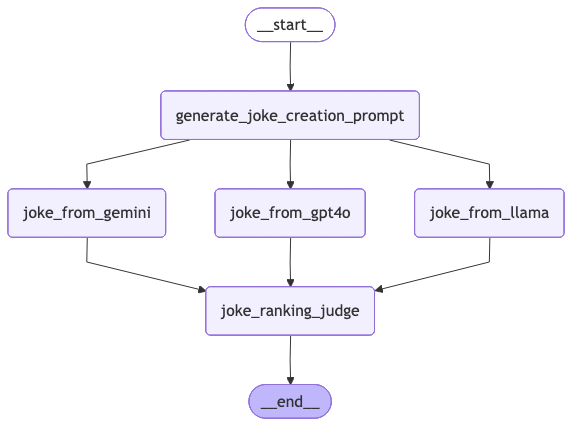

In [9]:
from IPython.display import display
import sys
from pathlib import Path

# Assuming notebook is in notebooks/ folder
project_root = Path().resolve().parent  # adjust if needed
sys.path.append(str(project_root))

from utils.mermaid import save_and_render_langgraph_mermaid

save_and_render_langgraph_mermaid(joke_ranking_workflow,"joke_ranking_workflow.png")

In [10]:
#joke_ranking_workflow.invoke({"topic":"school teachers"})